In [126]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler

import missingno as msno
import seaborn as sns

In [127]:
def automate_data_processing(df, target_column, missing_value_threshold=0.5):
    threshold = len(df) * missing_value_threshold
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    
    df_cleaned = df_cleaned.dropna(subset=[target_column])
    df_cleaned['main_category'] = df['main_category']
    y = df_cleaned[target_column]
    X = df_cleaned.drop(columns=[target_column])

    df_cleaned = df_cleaned.drop_duplicates()
    
    return df_cleaned, X, y

def clean_outliers(df):
    cols_100g = [col for col in df.columns if col.endswith('_100g')]

    df[cols_100g] = df[cols_100g].applymap(lambda x: abs(x) if pd.notnull(x) else x)

    nutrient_thresholds = {
        'energy_100g': 5000,
        'fat_100g': 100,
        'saturated-fat_100g': 90,
        'carbohydrates_100g': 100,
        'sugars_100g': 100,
        'fiber_100g': 45,
        'proteins_100g': 90,
        'salt_100g': 10,
        'sodium_100g': 6
    }

    for col in cols_100g:
        threshold = nutrient_thresholds.get(col, 100)
        df[col] = df[col].apply(lambda x: x if x <= threshold else float('NaN'))

    return df

In [128]:
df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')
df.head();

/tmp/ipykernel_30/1579681762.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')


In [129]:
df.shape

(320772, 162)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


On voit grâce a df.info() que nous avons **106 données quantitatives** et **56 données catégorielles**

**AFFICHAGE DES PROPORTIONS DE VALEURS MANQUANTES**

In [131]:
df.isna().mean()

code                       0.000072
url                        0.000072
creator                    0.000006
created_t                  0.000009
created_datetime           0.000028
                             ...   
carbon-footprint_100g      0.999165
nutrition-score-fr_100g    0.310382
nutrition-score-uk_100g    0.310382
glycemic-index_100g        1.000000
water-hardness_100g        1.000000
Length: 162, dtype: float64

**Appel de la fonction de préparation des données**

Notre target sera le Nutriscore qui peut facilement être prédit en fonction des qualités nutritives du produit tels que le sucre, le sel, les acides gras saturés, les protéines, etc...

In [132]:
target = 'nutrition_grade_fr'
df_cleaned, X, y = automate_data_processing(df, target)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221210 entries, 1 to 320768
Data columns (total 35 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     221210 non-null  object 
 1   url                                      221210 non-null  object 
 2   creator                                  221210 non-null  object 
 3   created_t                                221210 non-null  object 
 4   created_datetime                         221209 non-null  object 
 5   last_modified_t                          221210 non-null  object 
 6   last_modified_datetime                   221210 non-null  object 
 7   product_name                             218463 non-null  object 
 8   brands                                   216572 non-null  object 
 9   brands_tags                              216571 non-null  object 
 10  countries                            

Il nous reste après le nettoyage des valeurs manquantes **14 données quantitatives** et **21 données catégorielles**. On supprime les features inutiles

In [133]:
df_cleaned = df_cleaned.drop(columns=['code','url','creator','created_t','created_datetime', 'last_modified_t', 'last_modified_datetime','brands','countries','countries_fr','additives_n','ingredients_from_palm_oil_n', 'states_tags', 'states_fr', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'serving_size'])

On vérifie les dimensions de notre ensemble

In [134]:
df_cleaned.shape

(221210, 18)

In [135]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221210 entries, 1 to 320768
Data columns (total 18 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   product_name                             218463 non-null  object 
 1   brands_tags                              216571 non-null  object 
 2   countries_tags                           221153 non-null  object 
 3   ingredients_text                         196179 non-null  object 
 4   additives                                196158 non-null  object 
 5   ingredients_that_may_be_from_palm_oil_n  196179 non-null  float64
 6   nutrition_grade_fr                       221210 non-null  object 
 7   states                                   221210 non-null  object 
 8   energy_100g                              221019 non-null  float64
 9   fat_100g                                 203733 non-null  float64
 10  saturated-fat_100g                   

In [136]:
df_cleaned[target].isna().mean()

0.0

On supprime les doublons

In [137]:
df_cleaned = df_cleaned.drop_duplicates()

In [138]:
features = df_cleaned.columns
X = df_cleaned[features]
X.info();

<class 'pandas.core.frame.DataFrame'>
Index: 218756 entries, 1 to 320768
Data columns (total 18 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   product_name                             216036 non-null  object 
 1   brands_tags                              214148 non-null  object 
 2   countries_tags                           218699 non-null  object 
 3   ingredients_text                         193770 non-null  object 
 4   additives                                193749 non-null  object 
 5   ingredients_that_may_be_from_palm_oil_n  193770 non-null  float64
 6   nutrition_grade_fr                       218756 non-null  object 
 7   states                                   218756 non-null  object 
 8   energy_100g                              218565 non-null  float64
 9   fat_100g                                 201295 non-null  float64
 10  saturated-fat_100g                   

**Premiere Visualisation**

On restreint notre projet aux produits vendus en France et dans ses DOM-TOMs

In [139]:
keywords = [
    'france', 'guadeloupe', 'martinique', 'guyane', 'reunion', 'mayotte', 
    'saint-pierre-et-miquelon', 'saint-barthélemy', 'saint-martin',
    'polynésie française', 'nouvelle-calédonie', 'wallis-et-futuna', 'french-guiana'
]

X = X[X['countries_tags'].str.contains('|'.join(keywords), case=False, na=False)]

X.head();

In [140]:
X.describe()

,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,40944.000000,6.130500e+04,44192.000000,61305.000000,44139.000000,61305.000000,44789.000000,61305.000000,61305.000000,61305.000000
mean,0.164737,1.181462e+03,13.333382,5.436523,27.824554,13.399329,2.542855,7.736284,1.081633,0.425840
std,0.471337,1.317430e+04,16.761826,8.551384,27.270595,19.022072,4.614762,7.838205,3.809723,1.499843
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.350000e+02,1.400000,0.300000,4.200000,1.000000,0.000000,1.900000,0.080000,0.031496
50%,0.000000,1.041000e+03,7.000000,2.000000,14.900000,4.000000,1.380000,6.000000,0.550000,0.216535
75%,0.000000,1.661000e+03,21.000000,7.400000,53.000000,17.900000,3.200000,10.800000,1.220000,0.480315
max,5.000000,3.251373e+06,380.000000,210.000000,190.000000,104.000000,178.000000,100.000000,211.000000,83.000000


In [141]:
X.shape

(61386, 18)

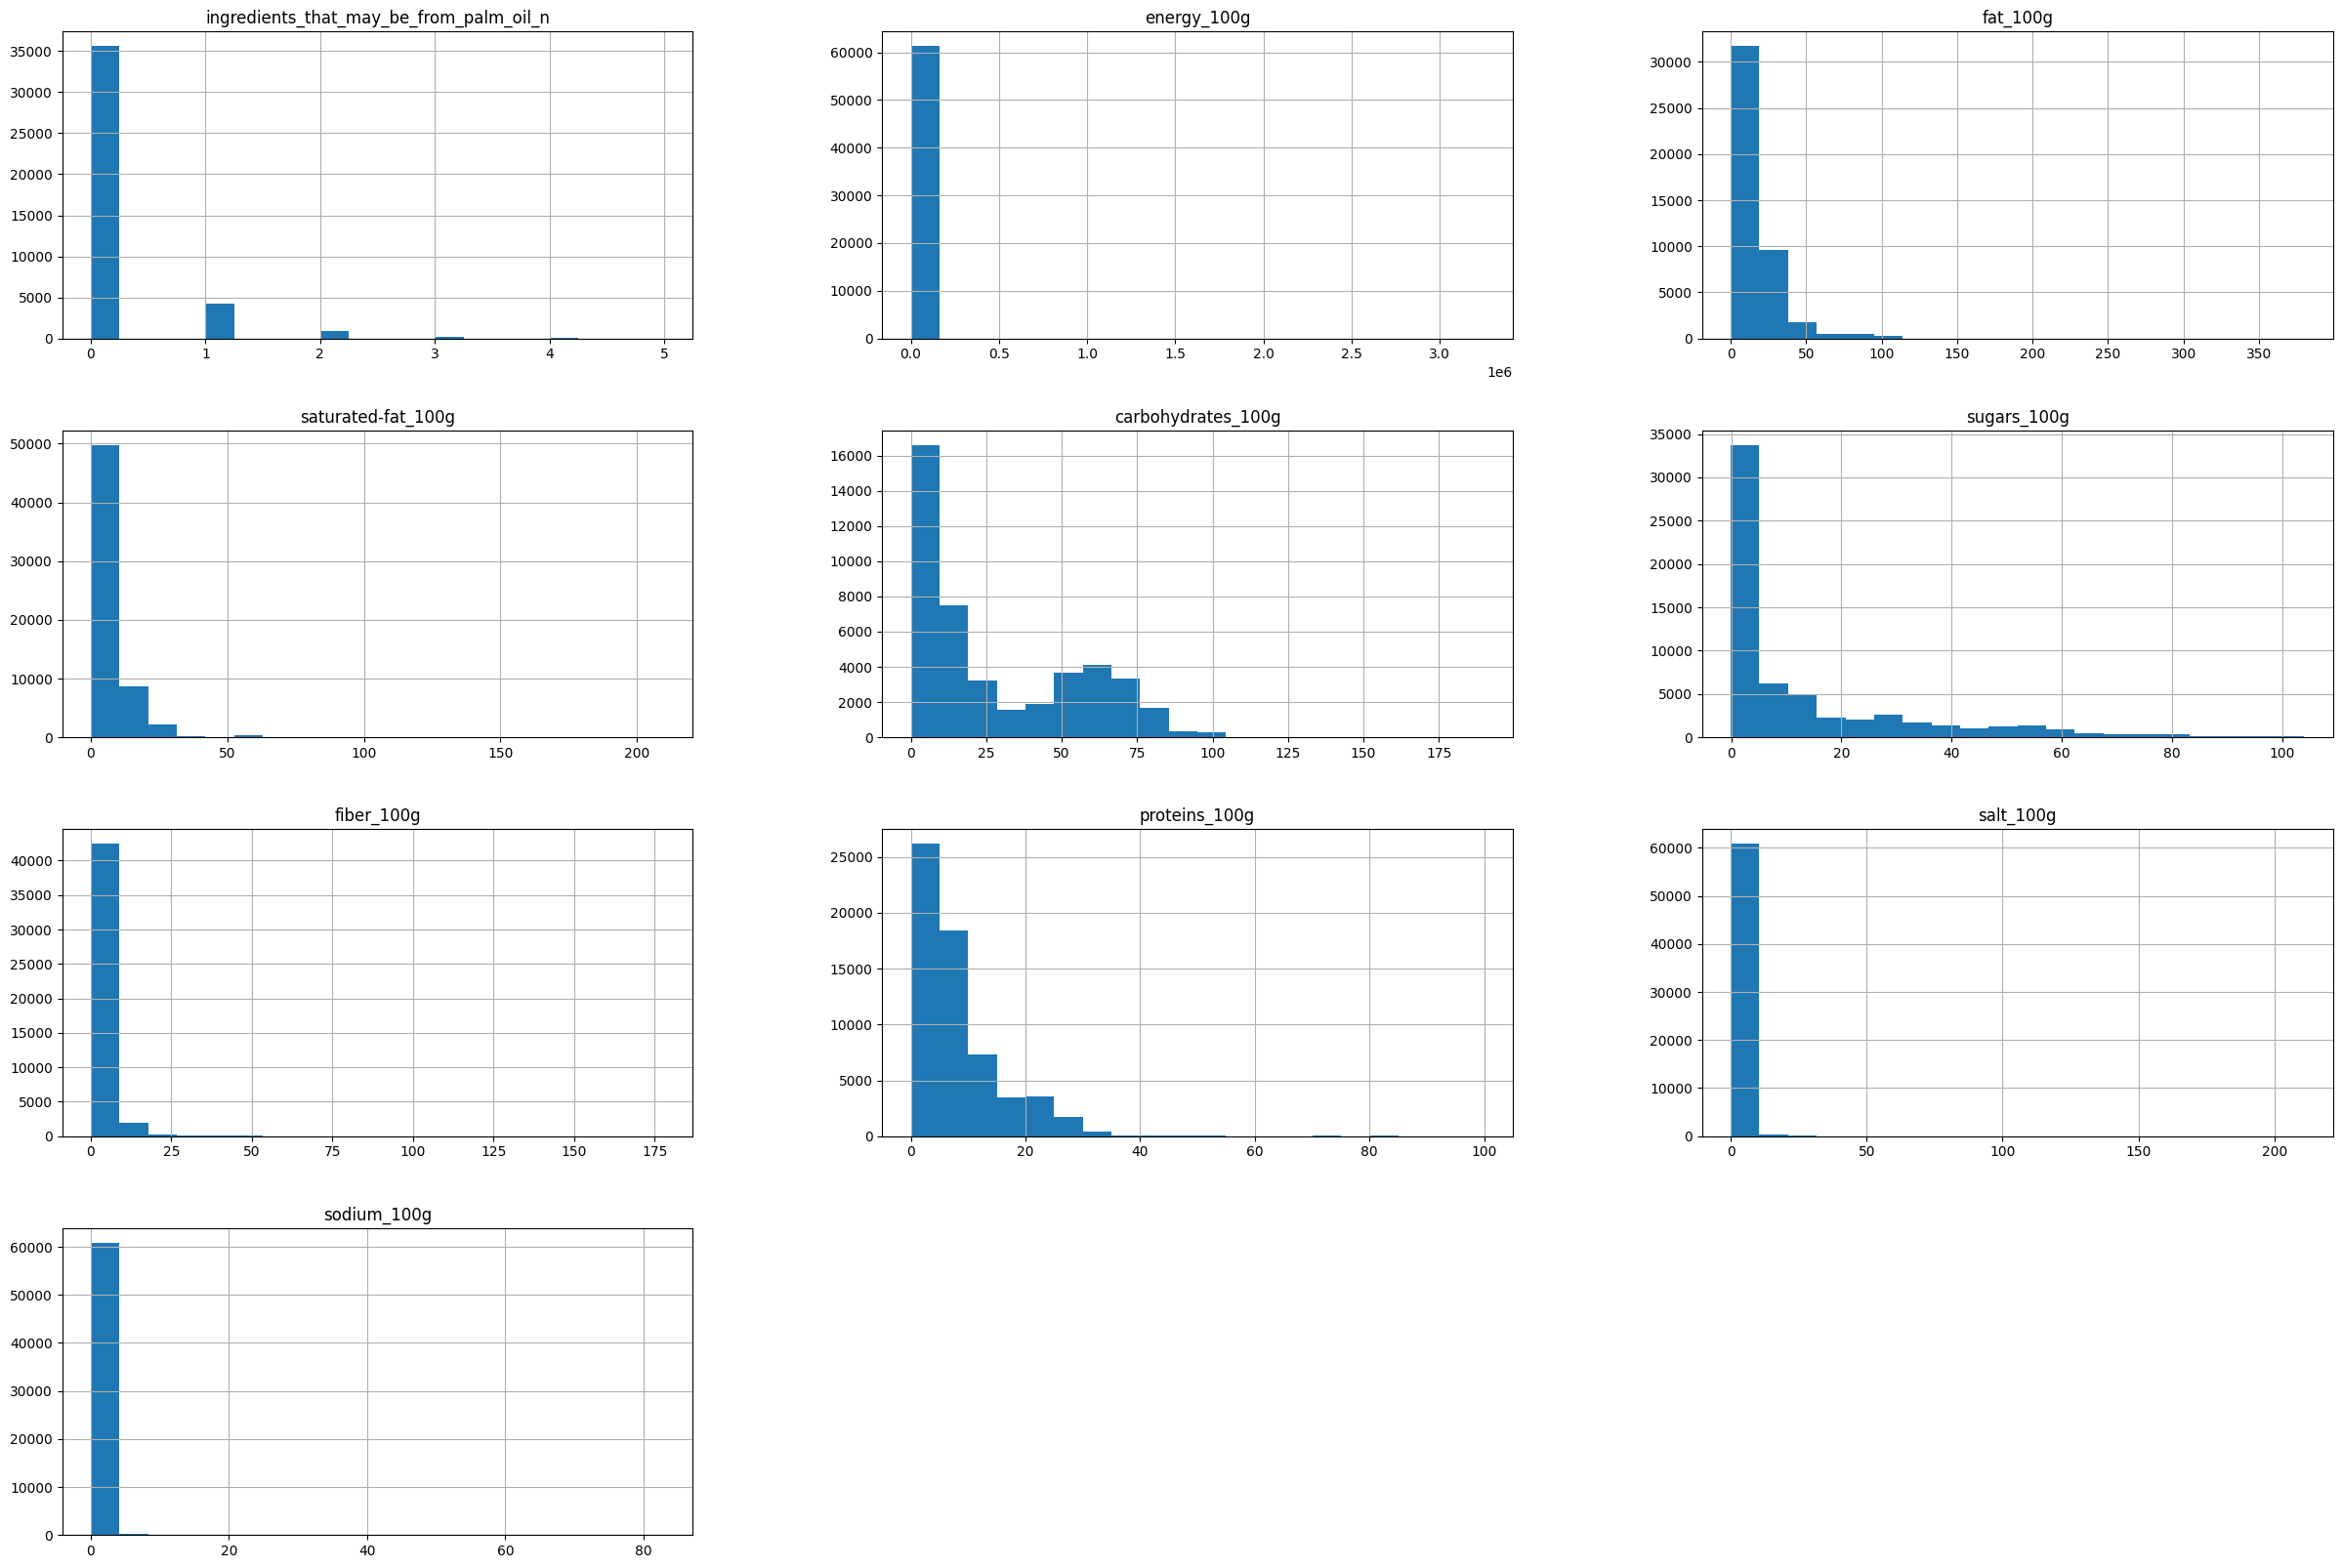

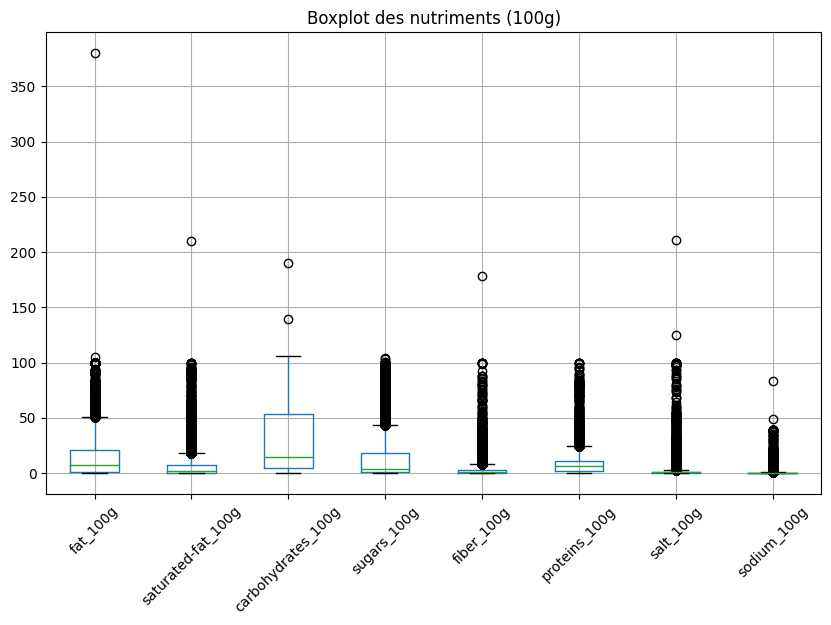

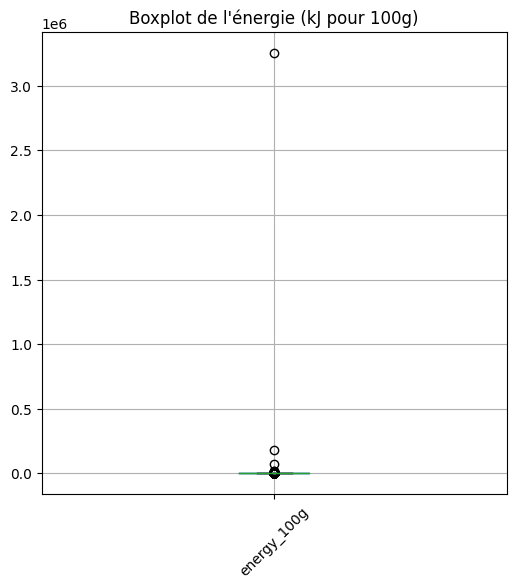

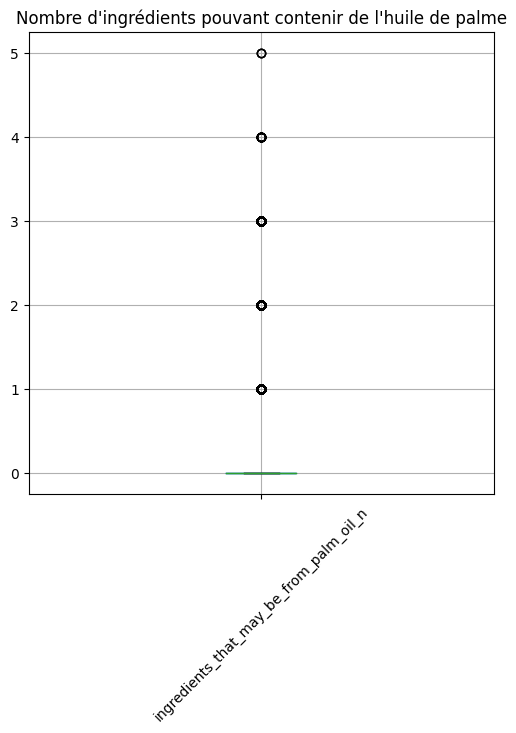

In [142]:
X.hist(bins=20, figsize=(30, 20))
plt.show()

nutriment_features = [col for col in X.columns if col.endswith('_100g') and col != 'energy_100g']

plt.figure(figsize=(10, 6))
X[nutriment_features].boxplot() 
plt.title("Boxplot des nutriments (100g)")
plt.xticks(rotation=45)
plt.show()

# Figure pour l'énergie
plt.figure(figsize=(6, 6))
X[['energy_100g']].boxplot()
plt.title("Boxplot de l'énergie (kJ pour 100g)")
plt.xticks(rotation=45)
plt.show()

# Figure pour l'énergie
plt.figure(figsize=(6, 6))
X[['ingredients_that_may_be_from_palm_oil_n']].boxplot()
plt.title("Nombre d'ingrédients pouvant contenir de l'huile de palme")
plt.xticks(rotation=45)
plt.show()

On supprime dans un premier temps les lignes ayant des valeurs aberrerantes d'un pdv métier

In [143]:
X = clean_outliers(X)

/tmp/ipykernel_30/563544744.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols_100g] = df[cols_100g].applymap(lambda x: abs(x) if pd.notnull(x) else x)


main_category
en:cakes            12
en:sugary-snacks    11
en:breakfasts        4
en:sandwiches        1
en:breads            1
en:pastries          1
Name: count, dtype: int64


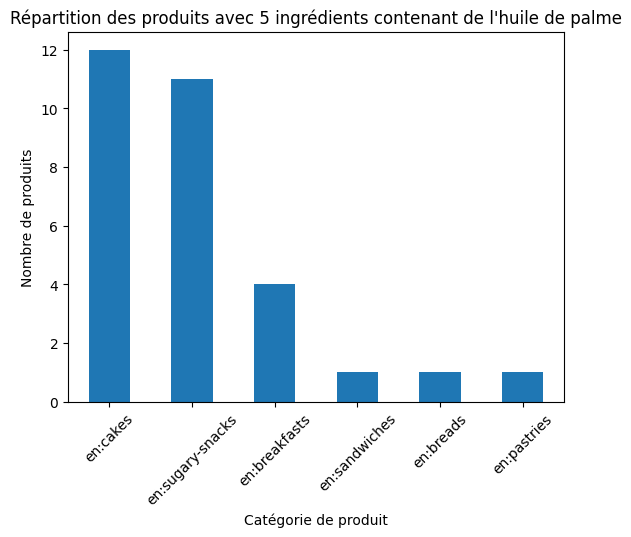

In [144]:
palm_oil_5_ingredients = X[X['ingredients_that_may_be_from_palm_oil_n'] >= 4]

print(palm_oil_5_ingredients['main_category'].value_counts())
palm_oil_5_ingredients['main_category'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=45)
plt.title("Répartition des produits avec 5 ingrédients contenant de l'huile de palme")
plt.show()

In [145]:
X.describe()

,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,40944.000000,61257.000000,44190.000000,61271.000000,44133.000000,61302.000000,44716.000000,61295.000000,60810.000000,60970.000000
mean,0.164737,1120.476391,13.323010,5.385415,27.811494,13.394959,2.437539,7.721594,0.835795,0.341343
std,0.471337,776.647622,16.665496,8.260676,27.246832,19.012256,3.705951,7.753926,1.081791,0.489094
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,434.000000,1.400000,0.300000,4.100000,1.000000,0.000000,1.900000,0.080000,0.031496
50%,0.000000,1040.000000,7.000000,2.000000,14.900000,4.000000,1.300000,6.000000,0.540000,0.216535
75%,0.000000,1658.000000,21.000000,7.400000,53.000000,17.900000,3.200000,10.800000,1.200000,0.472441
max,5.000000,4987.000000,100.000000,90.000000,100.000000,100.000000,45.000000,90.000000,10.000000,6.000000


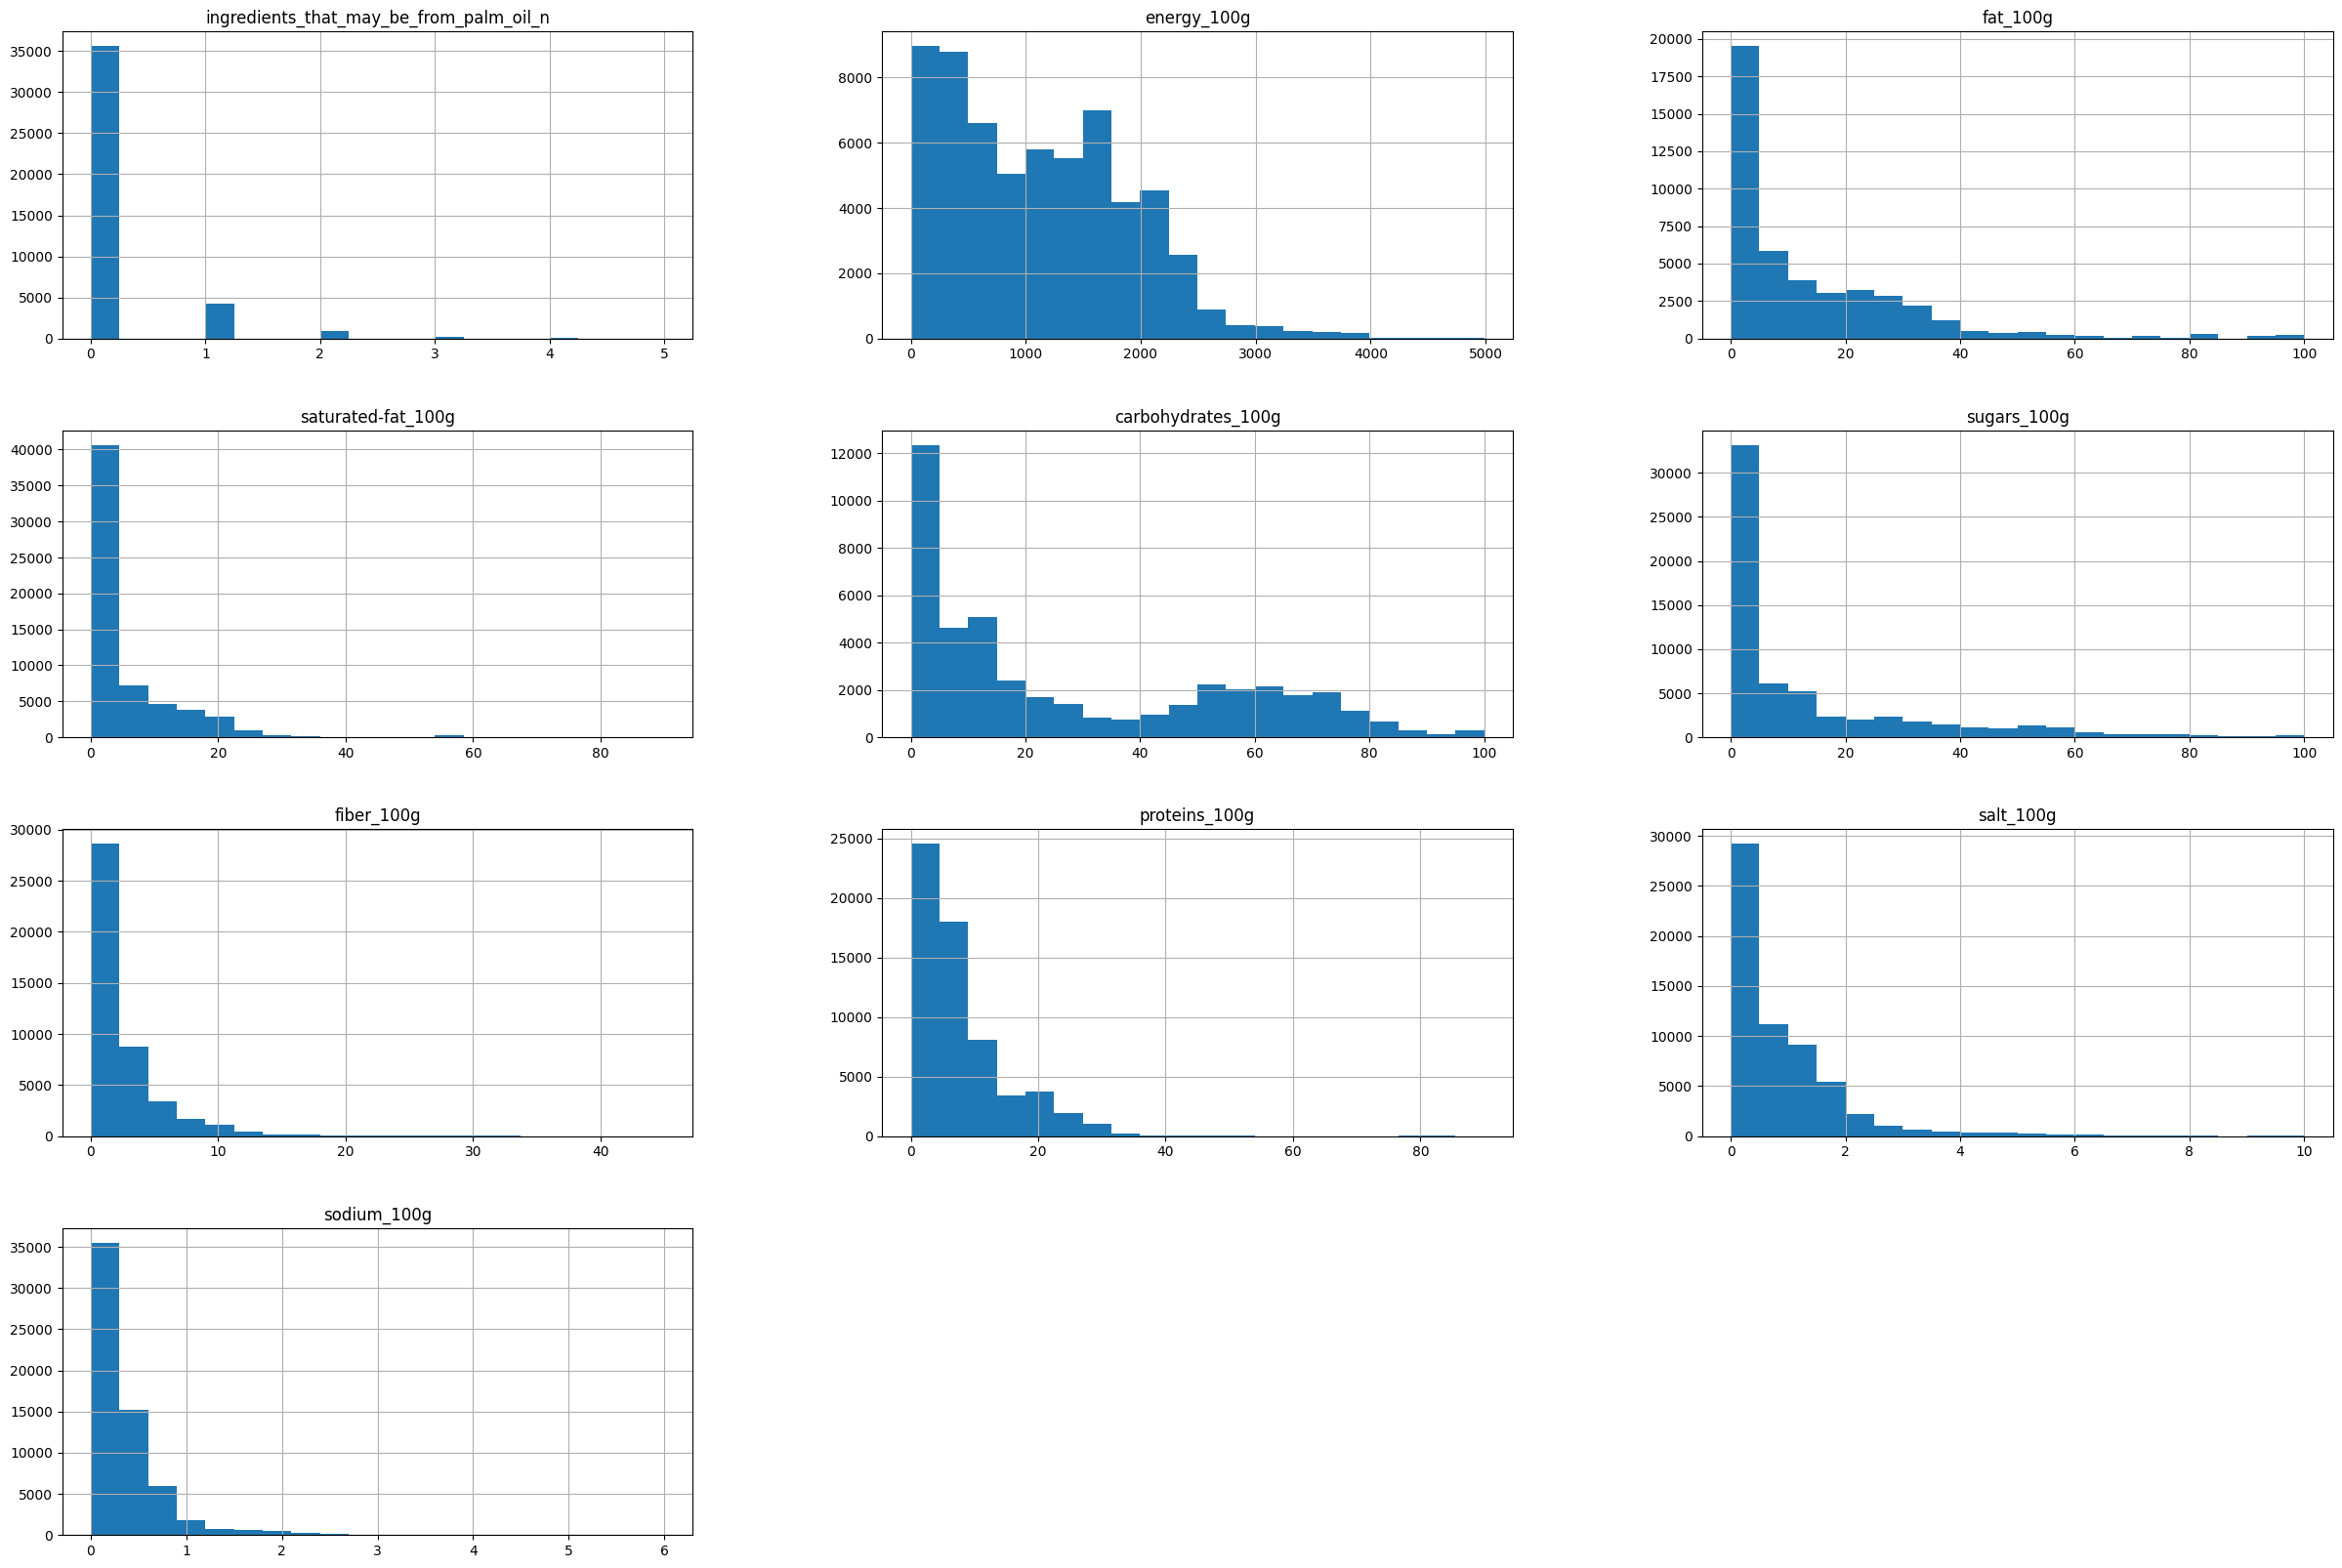

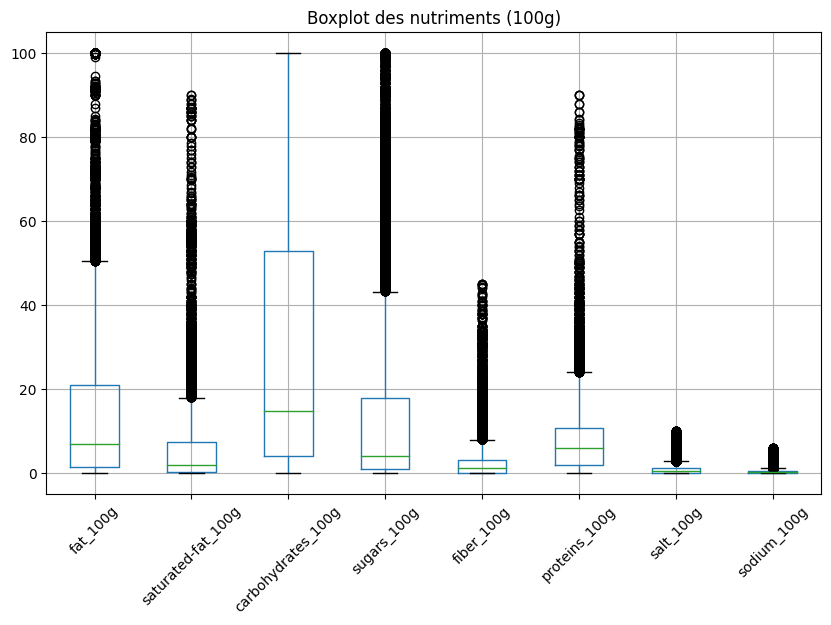

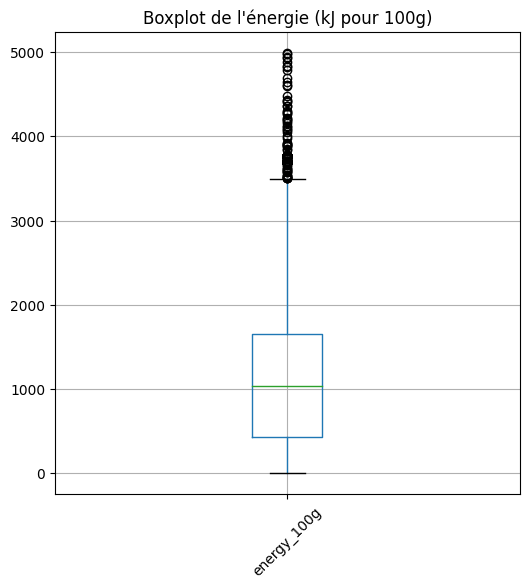

In [146]:
X.hist(bins=20, figsize=(30, 20))
plt.show()

plt.figure(figsize=(10, 6))
X[nutriment_features].boxplot() 
plt.title("Boxplot des nutriments (100g)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 6))
X[['energy_100g']].boxplot()
plt.title("Boxplot de l'énergie (kJ pour 100g)")
plt.xticks(rotation=45)
plt.show()

main_category
en:vegetable-oils       149
en:olive-oils            64
en:virgin-olive-oils     15
en:animal-fats            7
en:vegetable-fats         3
en:jams                   2
en:canned-sardines        2
en:dried-fruits           1
fr:lardons                1
en:pickles                1
en:sugary-snacks          1
en:nuts                   1
en:salted-spreads         1
en:pastas                 1
en:candies                1
en:fats                   1
en:biscuits               1
en:condiments             1
en:cheeses                1
en:butters                1
Name: count, dtype: int64


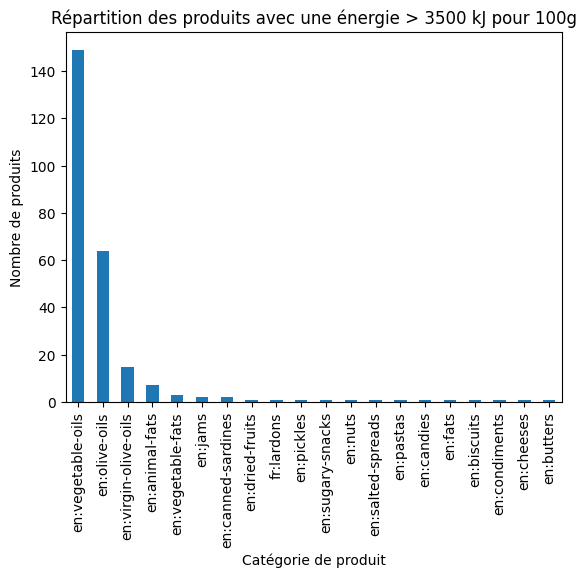

In [147]:
energy_threshold = 3500

high_energy_products = X[X['energy_100g'] > energy_threshold]

print(high_energy_products['main_category'].value_counts())

high_energy_products['main_category'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec une énergie > 3500 kJ pour 100g")
plt.show()

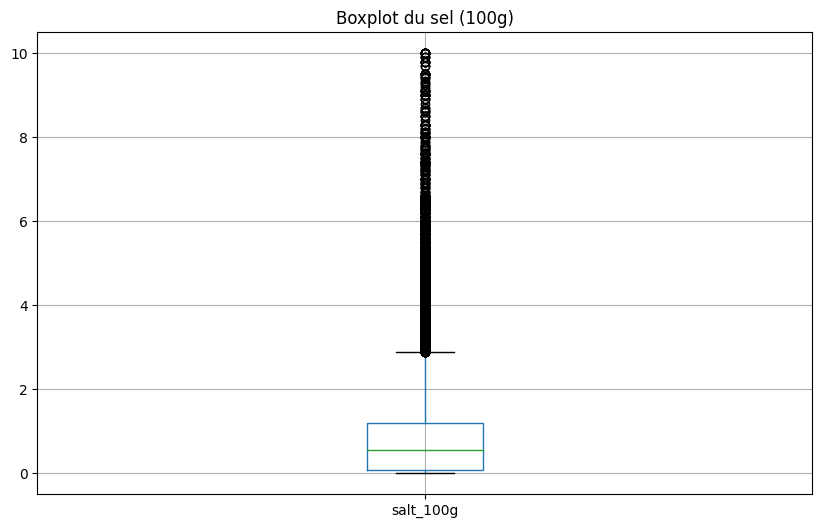

(array([1]), [Text(1, 0, 'sodium_100g')])

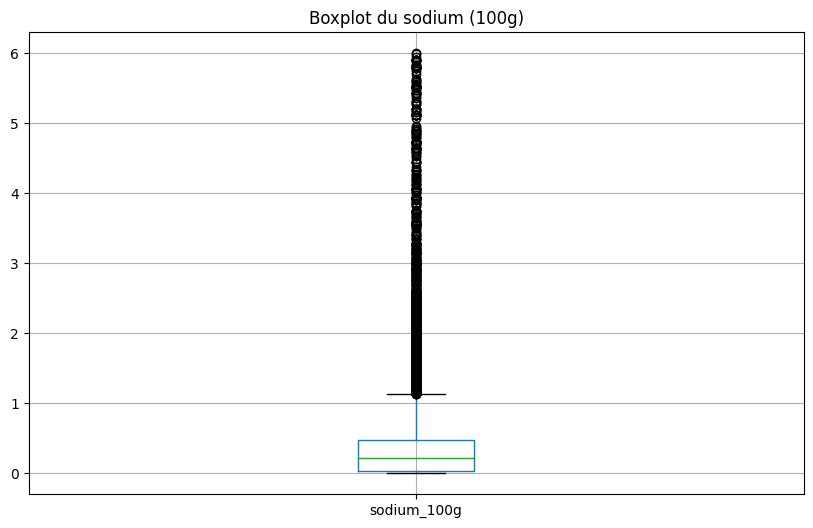

In [148]:
plt.figure(figsize=(10, 6))
X[['salt_100g']].boxplot() 
plt.title("Boxplot du sel (100g)")
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
X[['sodium_100g']].boxplot() 
plt.title("Boxplot du sodium (100g)")
plt.xticks(rotation=0)

main_category
en:condiments         183
en:dried-hams          71
en:groceries           55
fr:jambons-crus        37
fr:saucissons          25
                     ... 
en:petit-dejeuners      1
en:poultries            1
en:saucisson-sec        1
en:terrine              1
fr:wasabi               1
Name: count, Length: 71, dtype: int64


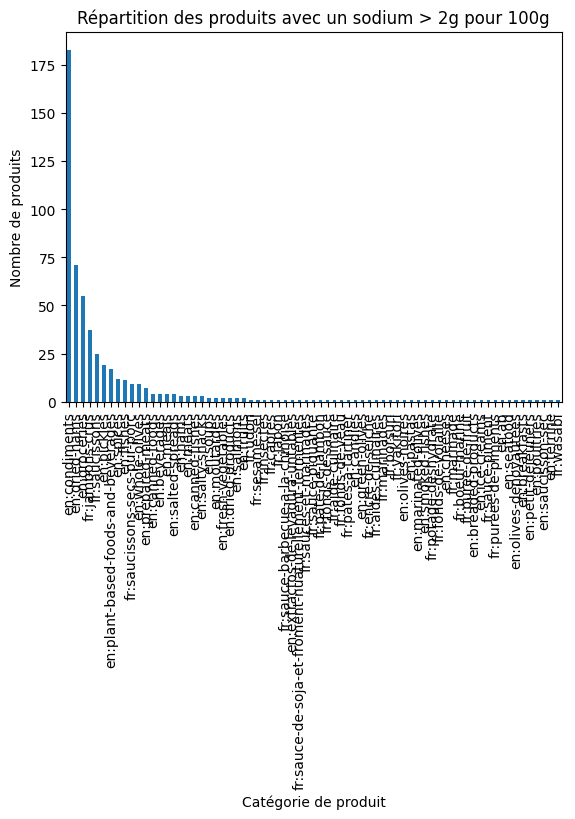

In [149]:
sodium_threshold = 2

high_sodium_products = X[X['sodium_100g'] > sodium_threshold]

print(high_sodium_products['main_category'].value_counts())

high_sodium_products['main_category'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec un sodium > 2g pour 100g")
plt.show()

main_category
en:condiments            213
fr:saucissons            183
en:dried-hams            110
fr:jambons-crus           63
en:groceries              57
                        ... 
en:seafood                 1
en:nuts                    1
en:olives-denoyautees      1
en:fresh-vegetables        1
fr:wasabi                  1
Name: count, Length: 75, dtype: int64


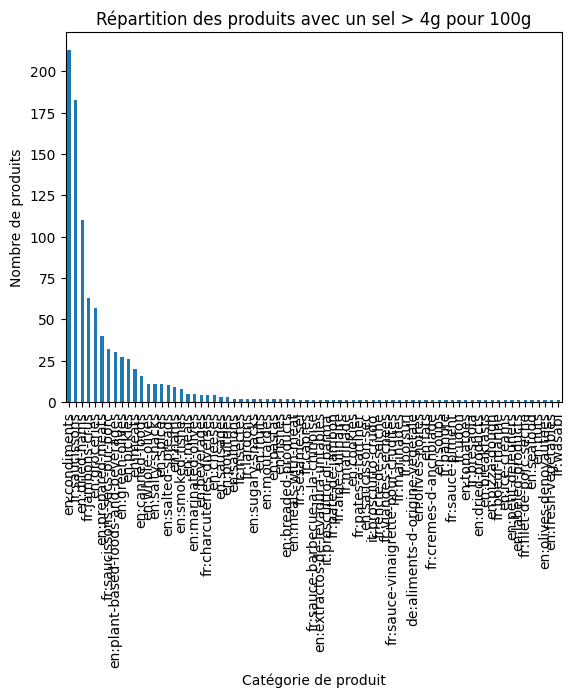

In [150]:
salt_threshold = 4

high_salt_products = X[X['salt_100g'] > salt_threshold]

print(high_salt_products['main_category'].value_counts())

high_salt_products['main_category'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec un sel > 4g pour 100g")
plt.show()

In [151]:
categorical_columns = X.select_dtypes(include='object').columns

for column in categorical_columns:
    exploded_values = X[column].str.split(',').explode()
    value_counts = exploded_values.value_counts(normalize=True) * 100
    print(f"\nFréquences pour '{column}':")
    print(value_counts)


Fréquences pour 'product_name':
product_name
                                         0.331071
 Surgelé                                 0.161756
Orange                                   0.072563
Mayonnaise                               0.065005
Huile d'olive vierge extra               0.061981
                                           ...   
Mayonnaise à la Moutarde à l'Ancienne    0.001512
Mayonnaise à la moutardes de dijon       0.001512
Brioche Fourrée Pocket Gout Chocolat     0.001512
Fromage blanc fondu (30 % MG)            0.001512
Thé vert Earl grey                       0.001512
Name: proportion, Length: 53769, dtype: float64

Fréquences pour 'brands_tags':
brands_tags
carrefour                    3.968517
auchan                       3.247849
u                            2.646139
marque-repere                2.589427
leader-price                 2.210419
                               ...   
belca                        0.001383
a-snc-hameau-de-st-didier    0.001383
le-mazet

In [152]:
print(X.isnull().sum())

product_name                                 341
brands_tags                                  348
countries_tags                                 0
ingredients_text                           20442
additives                                  20451
ingredients_that_may_be_from_palm_oil_n    20442
nutrition_grade_fr                             0
states                                         0
energy_100g                                  129
fat_100g                                   17196
saturated-fat_100g                           115
carbohydrates_100g                         17253
sugars_100g                                   84
fiber_100g                                 16670
proteins_100g                                 91
salt_100g                                    576
sodium_100g                                  416
main_category                              16912
dtype: int64


<Axes: >

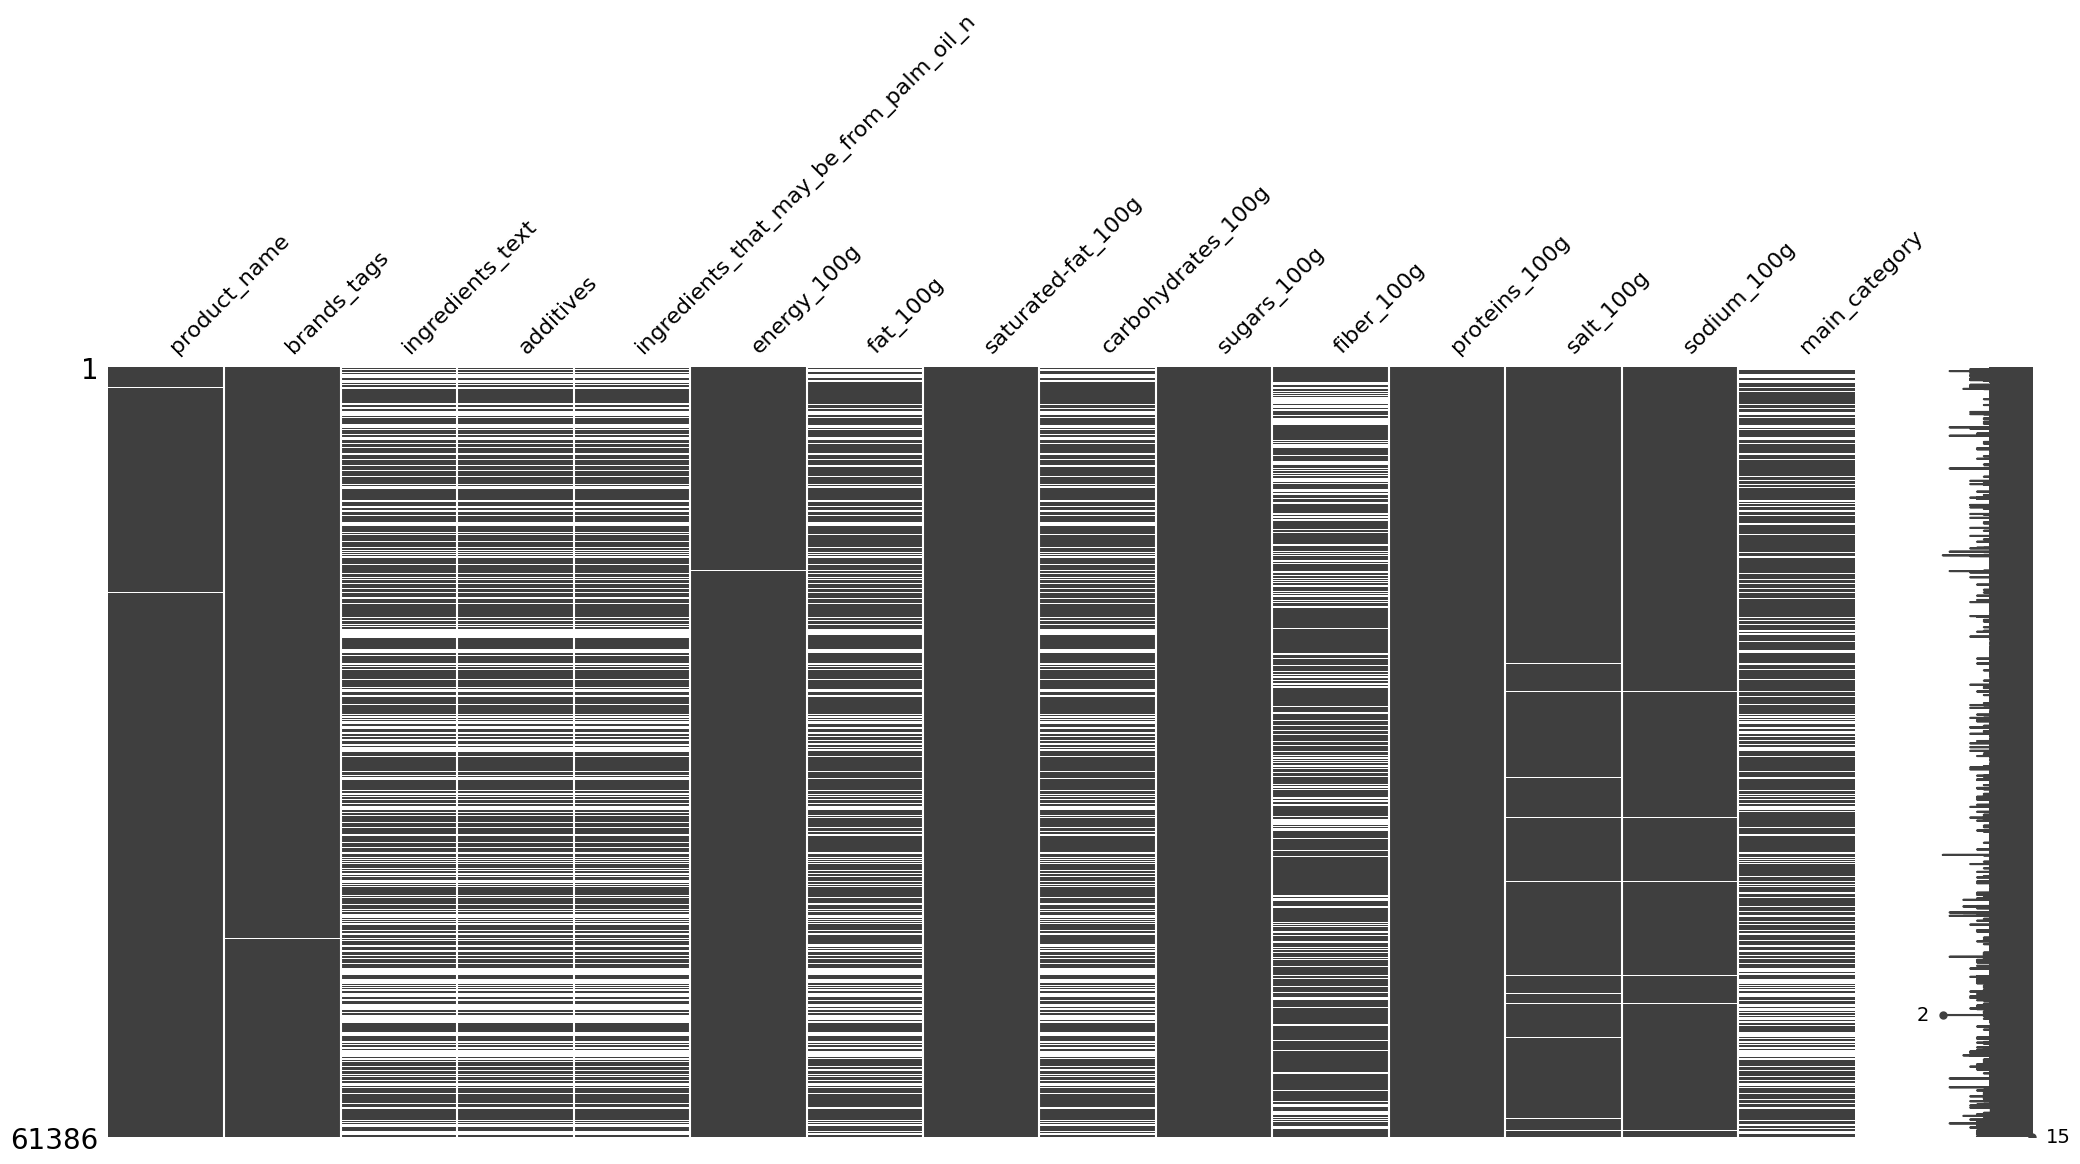

In [153]:
msno.matrix(X[X.columns[X.isnull().any()]])

Imputation à 0 des produits qui ne contiennent pas certains nutriments d'un point de vue métier

In [154]:
fiber_categories = 'boisson|sirop|sauce|biere|creme|glace|fromage|beurre|cigarette|lait|bonbon|caviar|cassonade|chocolat|dessert|pancake|faisselle|miel|yaourt|cancoillotte|cantal|cheese'
carbohydrate_categories = 'beurre|egg|poisson|produit_laitier|fromage|creme|oceansea|paella|thon|mozzarella|prosciutto|jambon'
salt_categories = 'substitution-de-repas|potage-deshydrate|poudres|purees-de-piments|cube-pour-soupe-miso|cubes|assaisionnement-bouillon'
saturated_fat_categories = 'fr:soupe-japonaise|en:gratins-de-legumes|en:salad|fr:plat-complet-adapte-a-l-enfant|fr:plat-prepare-pour-1-pers|fr:poudres'
fat_categories = 'dried-mango|fruits-secs|fruits-deshydrates|fond-d-artichauts|melange-salades|pointes-d-asperges-blanches|soupe-de-tomates|soupe-japonaise|jus-de-betterave|jus-orange-a-b-se-de-concentrer|jus-de-fruits|assaisionnement-bouillon|sauce-au-raifort|sauce-cocktail|creme-balsamique-de-modene|sucre-blanc-semoule-fine|melange-de-sucre-de-canne-et-de-stevia|sel-fin-iode-fluore|chips-de-banane|poudre|gnocchi|crepes-dentelle|vermicelle-de-soja|boissons-vegetales|eau-minerale-naturelle-gazeifiee|sirops-de-menthe|lait-concente-sucre'
sugar_categories = 'gratins-de-legumes|salad|plat-complet-adapte-a-l-enfant|poudres|soupe-japonaise'
protein_categories = 'gratins-de-legumes|salad|plat-complet-adapte-a-l-enfant|plat-prepare-pour-1-pers|poudres|soupe-japonaise'
sodium_categories = 'calissons'

In [155]:
X.loc[X['main_category'].str.contains(fiber_categories, case=False, na=False), 'fiber_100g'] = 0
X.loc[X['main_category'].str.contains(carbohydrate_categories, case=False, na=False), 'carbohydrates_100g'] = 0
X.loc[X['main_category'].str.contains(salt_categories, case=False, na=False), 'salt_100g'] = 0
X.loc[X['main_category'].str.contains(saturated_fat_categories, case=False, na=False), 'saturated-fat_100g'] = 0
X.loc[X['main_category'].str.contains(fat_categories, case=False, na=False), 'fat_100g'] = 0
X.loc[X['main_category'].str.contains(sugar_categories, case=False, na=False), 'sugars_100g'] = 0
X.loc[X['main_category'].str.contains(protein_categories, case=False, na=False), 'proteins_100g'] = 0
X.loc[X['main_category'].str.contains(sodium_categories, case=False, na=False), 'sodium_100g'] = 0

In [156]:
missing_percentage = X.groupby('main_category').apply(lambda x: x.isnull().mean())

categories_with_100_percent_missing = missing_percentage == 1.0

for category in categories_with_100_percent_missing.index:
    true_columns = categories_with_100_percent_missing.columns[categories_with_100_percent_missing.loc[category]]
    if not true_columns.empty:
        print(f"Catégorie: {category}")
        print("Features avec 100% de valeurs manquantes:", list(true_columns))
        print("\n")

Catégorie: de:aperitif
Features avec 100% de valeurs manquantes: ['fiber_100g']


Catégorie: de:barres
Features avec 100% de valeurs manquantes: ['fiber_100g']


Catégorie: de:flammekueche
Features avec 100% de valeurs manquantes: ['product_name', 'ingredients_text', 'additives', 'ingredients_that_may_be_from_palm_oil_n']


Catégorie: de:gateaux
Features avec 100% de valeurs manquantes: ['ingredients_text', 'additives', 'ingredients_that_may_be_from_palm_oil_n', 'fiber_100g']


Catégorie: de:petit-dejeuners
Features avec 100% de valeurs manquantes: ['fiber_100g']


Catégorie: de:snack
Features avec 100% de valeurs manquantes: ['ingredients_text', 'additives', 'ingredients_that_may_be_from_palm_oil_n']


Catégorie: en:ab
Features avec 100% de valeurs manquantes: ['ingredients_text', 'additives', 'ingredients_that_may_be_from_palm_oil_n', 'fat_100g', 'carbohydrates_100g', 'salt_100g']


Catégorie: en:baked-beans-with-pork-sausages-in-tomato-sauce
Features avec 100% de valeurs manquantes:

/tmp/ipykernel_30/2530602815.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_percentage = X.groupby('main_category').apply(lambda x: x.isnull().mean())


In [157]:
de_barres = X[X['main_category'] == 'en:by-appointment-to-her-majesty-queen-elizabeth-ii']
display(de_barres)

,product_name,brands_tags,countries_tags,ingredients_text,additives,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,main_category
69125,Soothing Chamomile & Honey,twinings,"en:france,en:new-zealand","Camomile, natural vanilla & honey flavourings ...",[ camomile -> en:camomile ] [ natural-vanil...,0.0,b,"en:to-be-checked, en:complete, en:nutrition-fa...",10.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,en:by-appointment-to-her-majesty-queen-elizabe...


<Axes: >

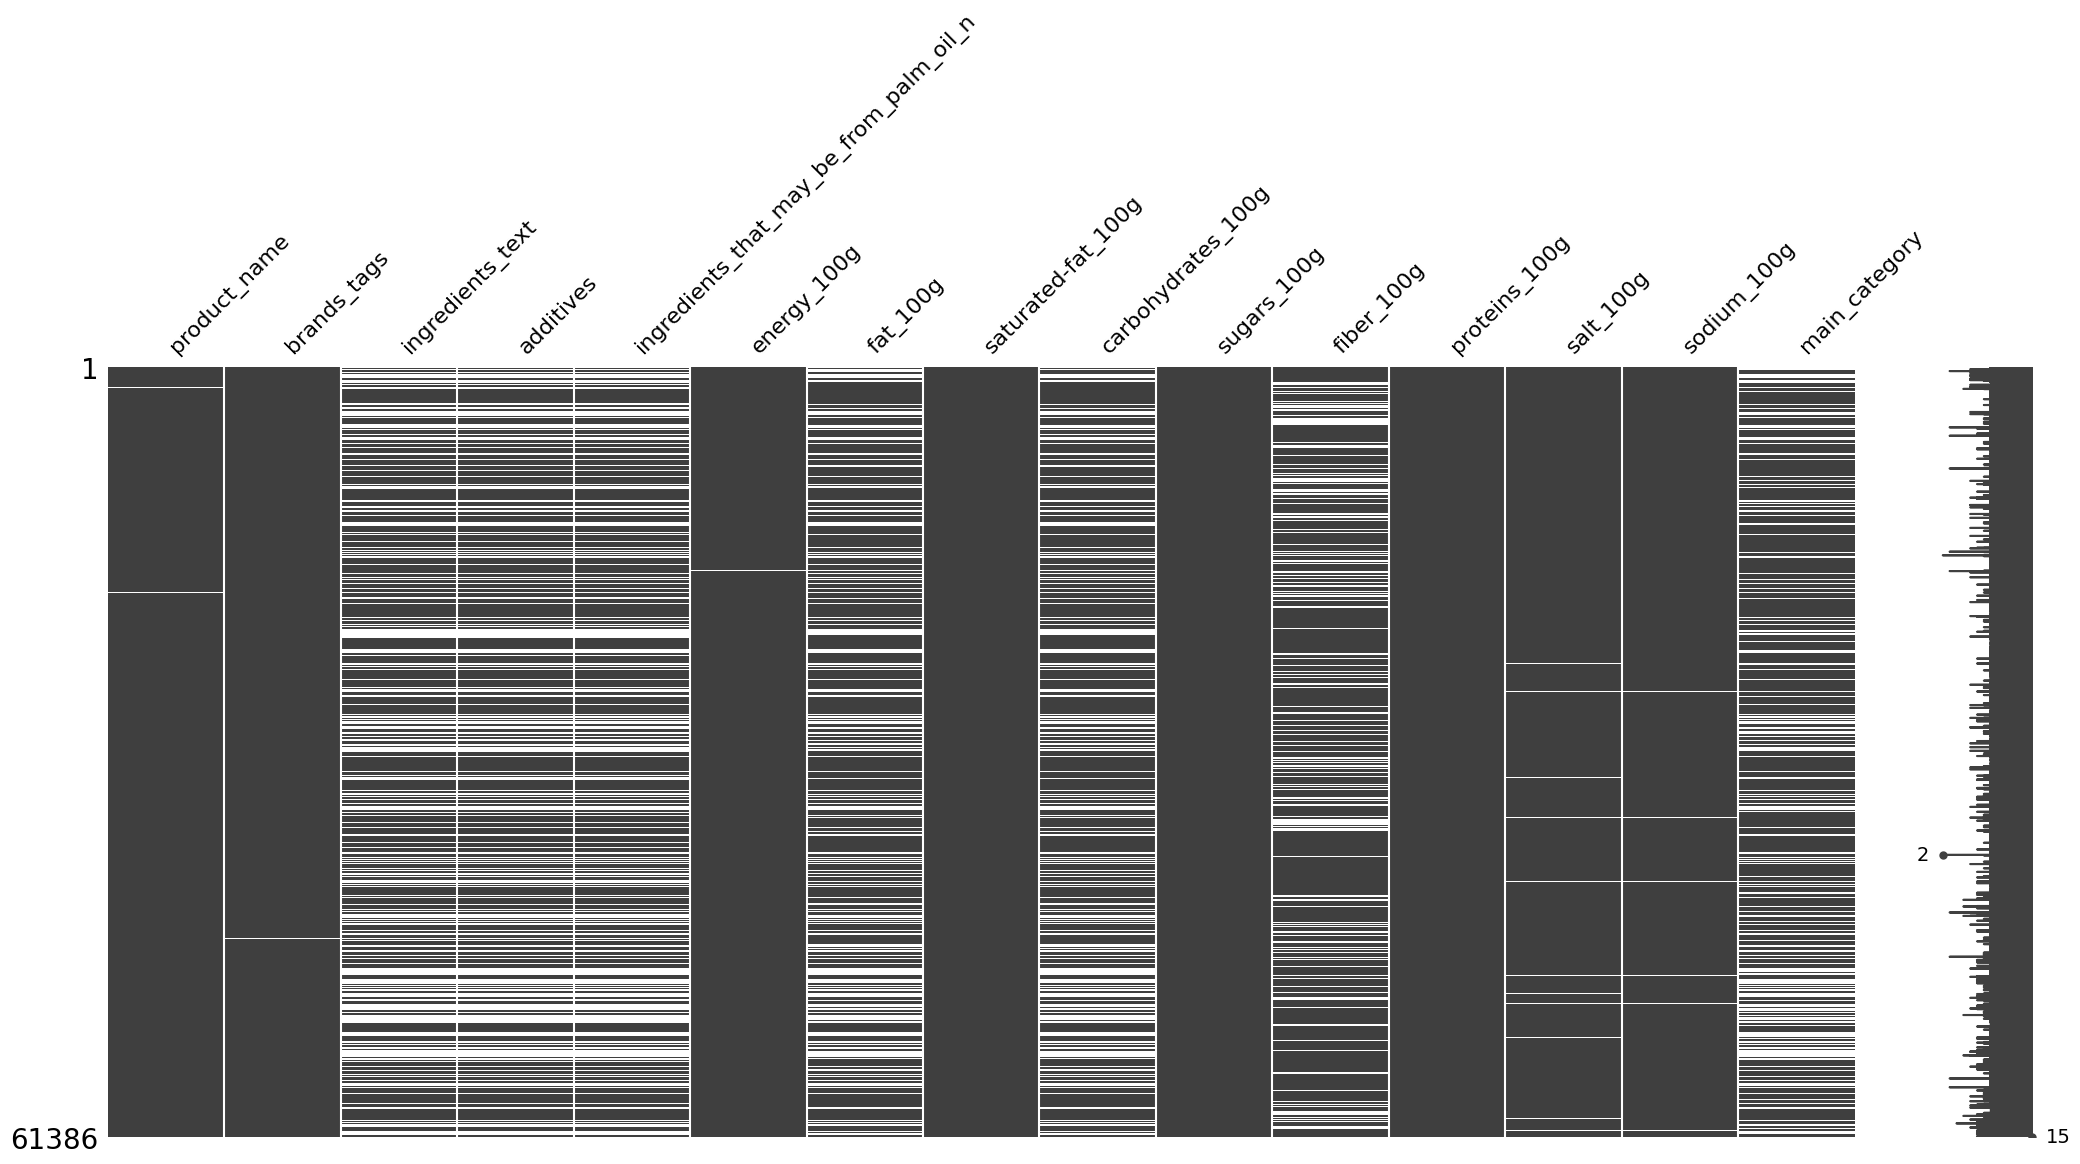

In [158]:
msno.matrix(X[X.columns[X.isnull().any()]])

In [159]:
missing_percentage_by_category = X.groupby('main_category').apply(lambda x: x.isnull().mean())

categories_to_drop = missing_percentage_by_category[missing_percentage_by_category > 0.8].dropna(how='all').index

X = X[~X['main_category'].isin(categories_to_drop)]

print(f"Catégories supprimées : {categories_to_drop}")
print(f"Dimensions du DataFrame après suppression : {X.shape}")

Catégories supprimées : Index(['de:aperitif', 'de:barres', 'de:flammekueche', 'de:gateaux',
       'de:petit-dejeuners', 'de:snack', 'en:ab', 'en:animal-fats',
       'en:baked-beans-with-pork-sausages-in-tomato-sauce',
       'en:barres-de-cereales',
       ...
       'it:pate-de-ble-dur', 'it:pates', 'it:petit-dejeuners',
       'it:prosciutto-crudo', 'it:proscuitto-di-parma',
       'nl:biscuits-et-gateaux', 'nl:chocolade', 'nl:pancakes', 'pt:bolachas',
       'th:biscuit-asiatique'],
      dtype='object', name='main_category', length=354)
Dimensions du DataFrame après suppression : (60802, 18)


/tmp/ipykernel_30/2906005486.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_percentage_by_category = X.groupby('main_category').apply(lambda x: x.isnull().mean())


In [160]:
print(X.isnull().sum())

product_name                                 327
brands_tags                                  338
countries_tags                                 0
ingredients_text                           20228
additives                                  20237
ingredients_that_may_be_from_palm_oil_n    20228
nutrition_grade_fr                             0
states                                         0
energy_100g                                  120
fat_100g                                   17060
saturated-fat_100g                           108
carbohydrates_100g                         17096
sugars_100g                                   76
fiber_100g                                 14049
proteins_100g                                 83
salt_100g                                    512
sodium_100g                                  362
main_category                              16912
dtype: int64


In [161]:
# Filtrer uniquement les lignes avec une catégorie valide
mask_with_category = X['main_category'].notnull()

# Appliquer la transformation uniquement aux lignes avec une catégorie valide
for column in X.select_dtypes(include=['number']).columns:
    X.loc[mask_with_category, column] = (
        X.loc[mask_with_category]
        .groupby('main_category')[column]
        .transform(lambda x: x.fillna(x.median()))
    )

# Vérifier les valeurs manquantes restantes
print(X.isnull().sum())

product_name                                 327
brands_tags                                  338
countries_tags                                 0
ingredients_text                           20228
additives                                  20237
ingredients_that_may_be_from_palm_oil_n    15533
nutrition_grade_fr                             0
states                                         0
energy_100g                                   40
fat_100g                                   14369
saturated-fat_100g                            23
carbohydrates_100g                         14380
sugars_100g                                    6
fiber_100g                                   936
proteins_100g                                 12
salt_100g                                    269
sodium_100g                                  188
main_category                              16912
dtype: int64


In [162]:
# Filtrer les colonnes numériques
numeric_columns = X.select_dtypes(include=['number']).columns

# Calculer le pourcentage de valeurs manquantes par catégorie pour les colonnes numériques uniquement
missing_percentage = X.groupby('main_category')[numeric_columns].apply(lambda x: x.isnull().mean())

# Créer un DataFrame booléen indiquant les colonnes numériques avec +0 % de valeurs manquantes pour chaque catégorie
categories_with_100_percent_missing = missing_percentage > 0

# Afficher uniquement les features numériques pour lesquels chaque catégorie a 0% de valeurs manquantes
for category in categories_with_100_percent_missing.index:
    # Sélectionner les colonnes où la valeur est True pour cette catégorie
    true_columns = categories_with_100_percent_missing.columns[categories_with_100_percent_missing.loc[category]]
    if not true_columns.empty:
        print(f"Catégorie: {category}")
        print("Features numériques avec +0% de valeurs manquantes:", list(true_columns))
        print("\n")

<Axes: >

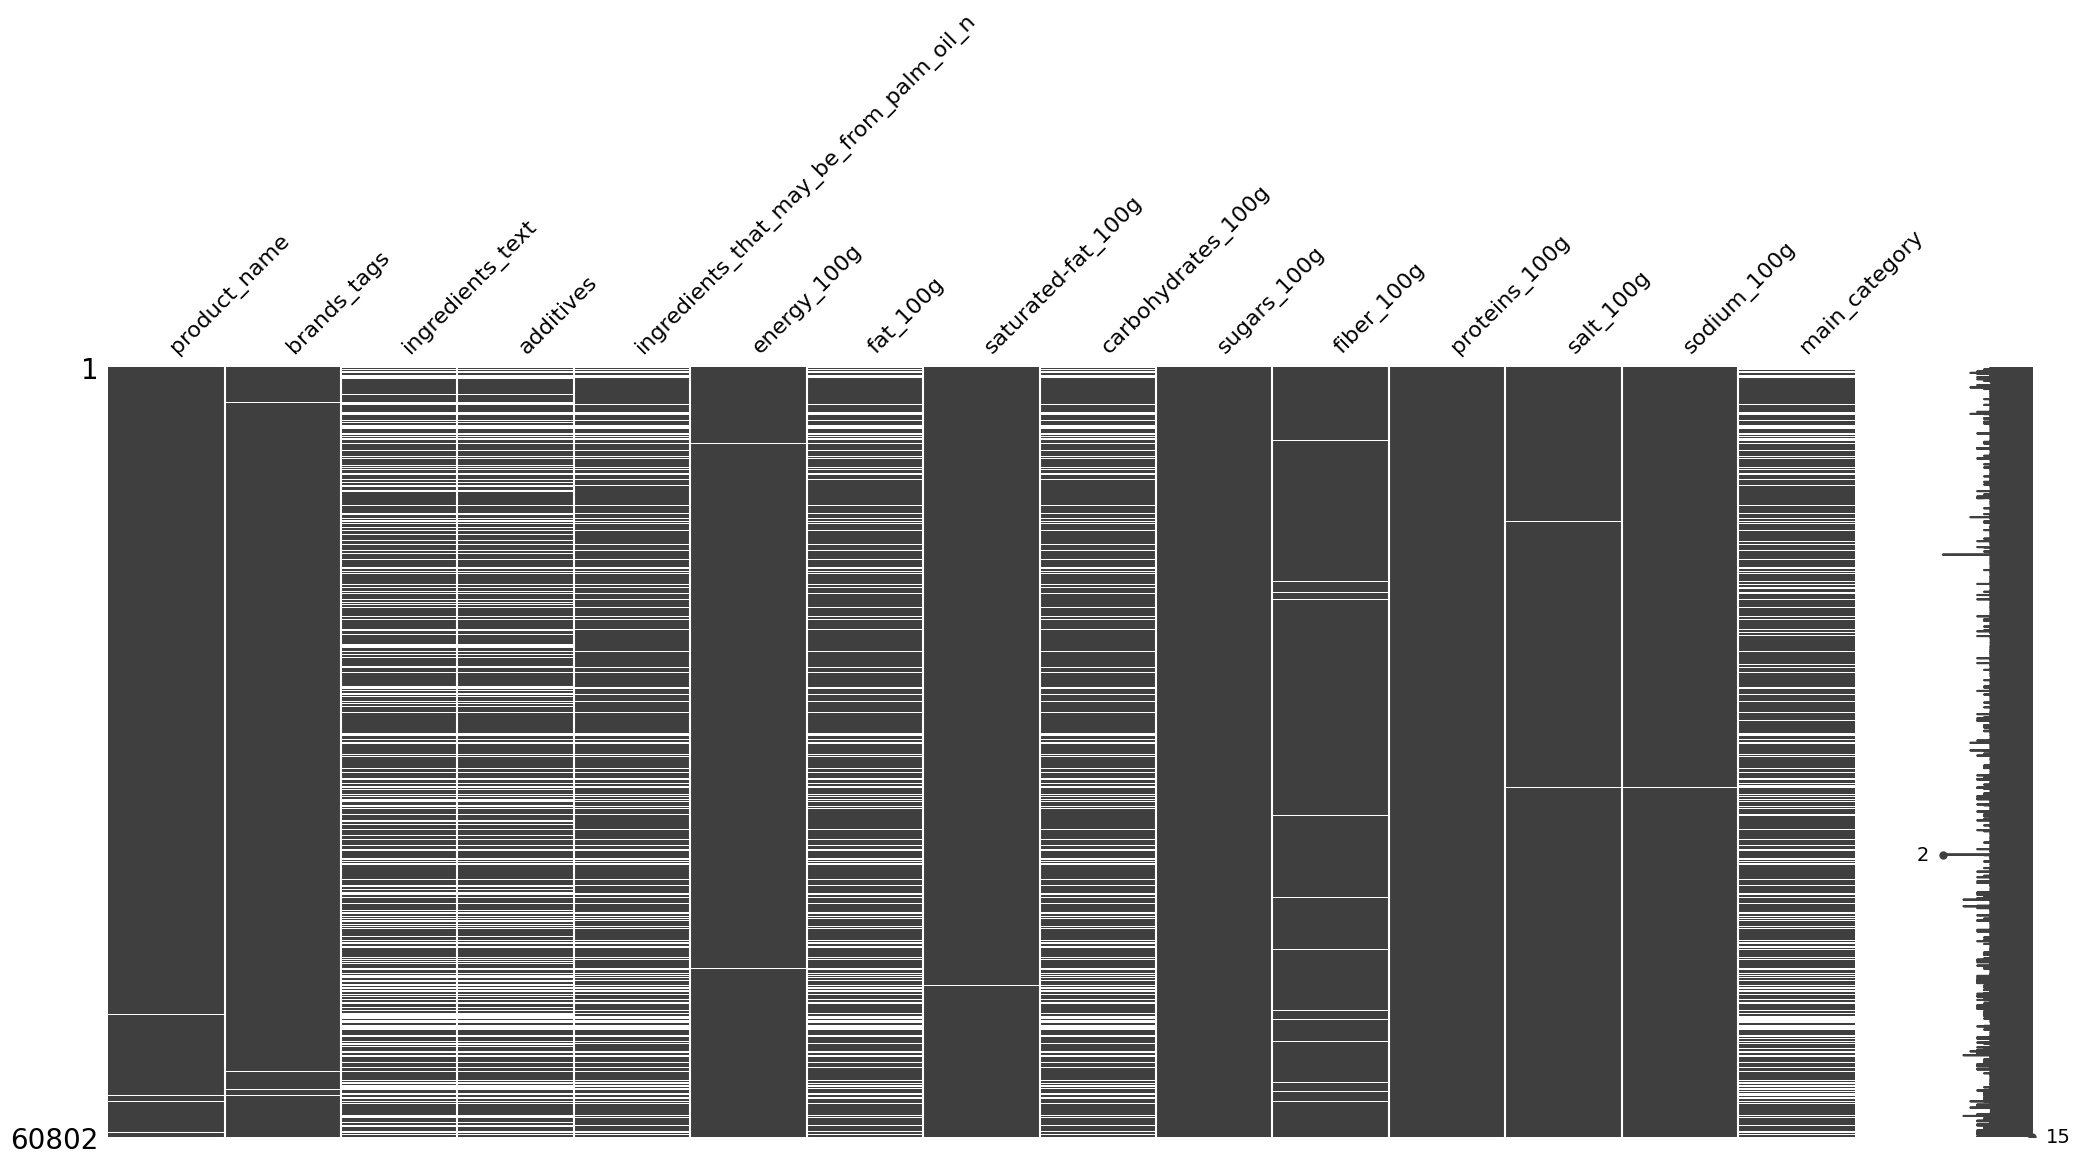

In [163]:
msno.matrix(X[X.columns[X.isnull().any()]])

In [164]:
# Filtrer les lignes où 'main_category' est vide ou manquante
produits_sans_categorie = X[X['main_category'].isnull() | (X['main_category'] == '')]

# Afficher les produits sans catégorie
print("Produits sans catégorie :")
display(produits_sans_categorie)

Produits sans catégorie :


,product_name,brands_tags,countries_tags,ingredients_text,additives,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,main_category
106,Lion Peanut x2,sunridge,"en:france,en:united-states","Milk chocolate coating (evaporated cane juice,...",[ milk-chocolate-coating -> en:milk-chocolate...,0.0,e,"en:to-be-completed, en:nutrition-facts-complet...",1883.0,20.0,12.50,70.0,57.50,2.5,2.50,0.09652,0.038000,NaN
190,Mini Confettis,alice-delice,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",1753.0,NaN,0.80,NaN,87.70,0.9,0.60,0.01000,0.003937,NaN
191,Praliné Amande Et Noisette,alice-delice,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",2406.0,NaN,2.90,NaN,50.30,3.9,9.50,0.00300,0.001181,NaN
234,Tarte Poireaux Et Lardons,bo-frost,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",1079.0,NaN,11.00,NaN,1.00,1.4,7.50,0.80000,0.314961,NaN
307,Beignets framboises,intermarche,en:france,NaN,NaN,NaN,c,"en:to-be-completed, en:nutrition-facts-complet...",1272.0,NaN,1.70,NaN,12.70,0.0,5.80,0.70000,0.275591,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320690,Peanut & Popcorn With Dark Chocolate 12 x 45G,great-value,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",1883.0,NaN,7.80,NaN,34.10,5.4,10.90,0.40000,0.157480,NaN
320698,Eat Natural Protein Packed,biobio,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",1996.0,NaN,10.00,NaN,22.00,6.0,22.00,1.00000,0.393701,NaN
320740,Verrine Cheescake Myrtille,kayser,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",1084.0,NaN,12.00,NaN,10.50,0.0,8.70,0.29000,0.114173,NaN
320741,Fiche Brevet,hatier,en:france,NaN,NaN,NaN,b,"en:to-be-completed, en:nutrition-facts-complet...",4.0,NaN,1.00,NaN,1.00,10.0,10.00,10.00000,3.937008,NaN
